## Import Library

In [22]:
import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Flatten

## Fungsi Progress Animation

In [23]:
def print_progress(val, val_len, folder, bar_size=20):
    progr = "#"*round((val)*bar_size/val_len) + " "*round((val_len - (val))*bar_size/val_len)
    if val == 0:
        print("", end = "\n")
    else:
        print("[%s] (%d samples)\t label : %s \t\t" % (progr, val+1, folder), end="\r")

## Load Model Detection

In [24]:
from mtcnn_cv2 import MTCNN
detector_mtcnn = MTCNN()

In [25]:
from yoloface import face_analysis
face=face_analysis()

yolov3-tiny_face.weights:: status : file already exists
yolov3_tiny_face.cfg:: status : file already exists
face_detection.weights:: status : file already exists
face_detection.cfg:: status : file already exists


In [26]:
face_cascade = cv2.CascadeClassifier('haarcascade/haarcascade_frontalface_default.xml')

## Fungsi Face Detection

In [27]:
def detect_face_yolo(path):
    imgset = cv2.imread(path)
    imge,box,conf=face.face_detection(image_path=path,model='tiny')
    for (x, y, w, h) in box:
        img = imgset[y:y + w, x:x + h]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (224, 224))
        return img

In [28]:
def detect_face_haarcascade(img):
    face_img = img;
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    for (x, y, w, h) in faces:
        faces = img[y:y + h, x:x + w]
        imgx = cv2.cvtColor(faces, cv2.COLOR_BGR2GRAY)
        imgx = cv2.resize(imgx, (224, 224))
        return imgx

In [29]:
def detect_face_mtcnn(img):
    faces = detector_mtcnn.detect_faces(img)
    for face in faces:
        x, y, w, h = face['box']
        img = img[y:y + h, x:x + w]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = cv2.resize(img, (224, 224))
        return img

## Fungsi Chart

In [30]:
def print_data(names):
    unique, counts = np.unique(names, return_counts = True)
    label_distr = {i:names.count(i) for i in names}.values()
    plt.figure(figsize=(12,6))
    my_circle = plt.Circle( (0,0), 0.7, color='white')
    plt.pie(label_distr, labels=unique, autopct='%1.1f%%')
    plt.gcf().gca().add_artist(my_circle)
    plt.show()
    for item in zip(unique, counts):
        print(item)

## Fungsi Show Image Perbandingan Face Detection

In [31]:
def img_index(number):
    plt.rcParams["figure.figsize"] = [10.00, 3.50]
    plt.rcParams["figure.autolayout"] = False
    i1 = plt.subplot(1, 3, 1)
    i1.set_title("Haarcascade")
    plt.imshow(haar_images[number], cmap='gray')
    i2 = plt.subplot(1, 3, 2)
    i2.set_title("MTCNN")
    plt.imshow(mtcnn_images[number], cmap='gray')
    i3 = plt.subplot(1, 3, 3)
    i3.set_title("YOLO")
    plt.imshow(yolo_images[number], cmap='gray')
    plt.show()

## Fungsi Balancing

In [32]:
def randc(labels, l):
    return np.random.choice(np.where(np.array(labels) == l)[0], n, replace=True)

yolo_bal = []
mtcnn_bal = []
yolo_bn = []
mtcnn_bn = []

def balancing(names, images, title):
    mask = np.hstack([randc(names, l) for l in np.unique(names)])
    names = [names[m] for m in mask]
    images = [images[m] for m in mask]
    if title == "MTCNN":    
        mtcnn_bal.extend(images)
        mtcnn_bn.extend(names)
    elif title == "YOLO":
        yolo_bal.extend(images)
        yolo_bn.extend(names)
        
    print('\n\n' + title)
    print_data(names)
    print("Jumlah Data " + title + " setelah Balancing : ", len(names))
    balance = len(names)

## Fungsi Image Augmentation

In [33]:
def img_augmentation(img):
    h, w = img.shape
    center = (w // 2, h // 2)
    M_rot_5 = cv2.getRotationMatrix2D(center, 5, 1.0)
    M_rot_neg_5 = cv2.getRotationMatrix2D(center, -5, 1.0)
    M_rot_10 = cv2.getRotationMatrix2D(center, 10, 1.0)
    M_rot_neg_10 = cv2.getRotationMatrix2D(center, -10, 1.0)
    M_trans_3 = np.float32([[1, 0, 3], [0, 1, 0]])
    M_trans_neg_3 = np.float32([[1, 0, -3], [0, 1, 0]])
    M_trans_6 = np.float32([[1, 0, 6], [0, 1, 0]])
    M_trans_neg_6 = np.float32([[1, 0, -6], [0, 1, 0]])
    M_trans_y3 = np.float32([[1, 0, 0], [0, 1, 3]])
    M_trans_neg_y3 = np.float32([[1, 0, 0], [0, 1, -3]])
    M_trans_y6 = np.float32([[1, 0, 0], [0, 1, 6]])
    M_trans_neg_y6 = np.float32([[1, 0, 0], [0, 1, -6]])
    
    imgs = []
    imgs.append(cv2.warpAffine(img, M_rot_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_5, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_rot_neg_10, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y3, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.warpAffine(img, M_trans_neg_y6, (w, h), borderValue=(255,255,255)))
    imgs.append(cv2.add(img, 10))
    imgs.append(cv2.add(img, 30))
    imgs.append(cv2.add(img, -10))
    imgs.append(cv2.add(img, -30)) 
    imgs.append(cv2.add(img, 15))
    imgs.append(cv2.add(img, 45))
    imgs.append(cv2.add(img, -15))
    imgs.append(cv2.add(img, -45))
    
    return imgs

In [34]:
aug_img_mtcnn = []
aug_name_mtcnn = []

aug_img_yolo = []
aug_name_yolo = []

def augmented_data(images, names, title):
    print("Data Awal " + title + ":", len(ori_images))
    print("Data Balancing " + title + ":", len(names))
    
    augmented_images = []
    augmented_names = []

    for i, img in enumerate(images):
        try :
            augmented_images.extend(img_augmentation(img))
            augmented_names.extend([names[i]] * 20)
        except :
            print(i)
            
    if title == "YOLO":
        aug_img_yolo.extend(augmented_images)
        aug_name_yolo.extend(augmented_names)
    elif title == "MTCNN":
        aug_img_mtcnn.extend(augmented_images)
        aug_name_mtcnn.extend(augmented_names)
        
    print("Data Augmented " + title + ":", (len(augmented_images), len(augmented_names)))

## Fungsi Load Dataset

In [35]:
dataset_folder = "dataset/"

yolo_names = []
yolo_images = []

mtcnn_names = []
mtcnn_images = []

haar_names = []
haar_images = []

ori_images = []
total = []

for folder in os.listdir(dataset_folder):
    files = os.listdir(os.path.join(dataset_folder, folder))[:150]
    if len(files) < 50 :
        continue
    for i, name in enumerate(files): 
        if name.find(".jpg") > -1 :
            imgs = cv2.imread(os.path.join(dataset_folder + folder, name))
            haar = detect_face_haarcascade(imgs)
            mtcn = detect_face_mtcnn(imgs)
            path = dataset_folder + folder + "/" + name
            yolo = detect_face_yolo(path)
            if haar is not None :
                haar_images.append(haar)
                haar_names.append(folder)
            if mtcn is not None :
                mtcnn_images.append(mtcn)
                mtcnn_names.append(folder)
            if yolo is not None :
                yolo_images.append(yolo)
                yolo_names.append(folder)
            if imgs is not None :
                print_progress(i, len(files), folder)
                ori_images.append(imgs)
                total.append(folder)


[####################] (77 samples)	 label : Ariel_Sharon 		
[####################] (71 samples)	 label : Hugo_Chavez 		


In [36]:
print("Jumlah Dataset :", len(total))

Jumlah Dataset : 221


## Face Detection



HAARCASCADE


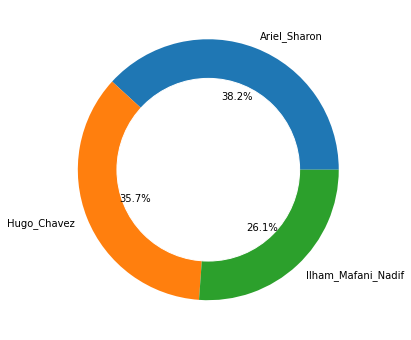

('Ariel_Sharon', 76)
('Hugo_Chavez', 71)
('Ilham_Mafani_Nadif', 52)


MTCNN


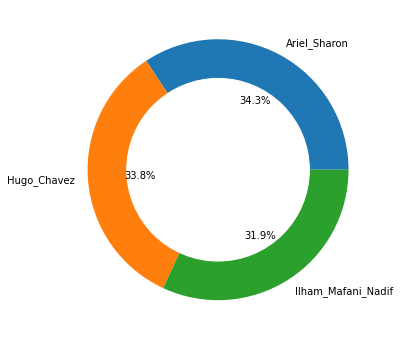

('Ariel_Sharon', 72)
('Hugo_Chavez', 71)
('Ilham_Mafani_Nadif', 67)


YOLO


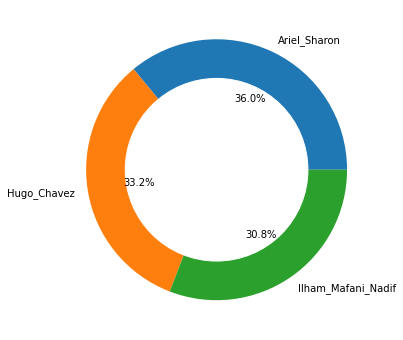

('Ariel_Sharon', 77)
('Hugo_Chavez', 71)
('Ilham_Mafani_Nadif', 66)


In [37]:
print("\n\nHAARCASCADE")
print_data(haar_names)

print("\n\nMTCNN")
print_data(mtcnn_names)

print("\n\nYOLO")
print_data(yolo_names)

## Sample Face Detection

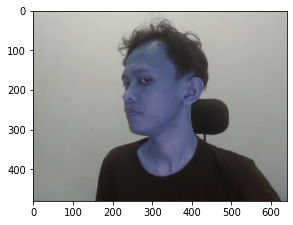

In [38]:
plt.imshow(ori_images[180], cmap='gray')
plt.show()

Gambar sebelum di lakukan deteksi wajah

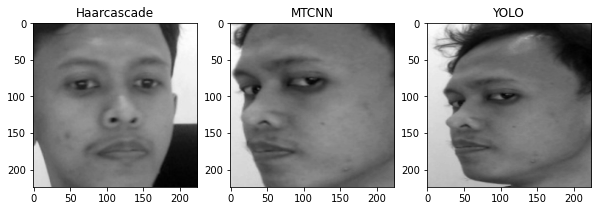

In [39]:
img_index(180)

Hasil Cropping Image dengan 3 Model Deteksi Objek Wajah (Face Detection)

In [40]:
n = 66



MTCNN


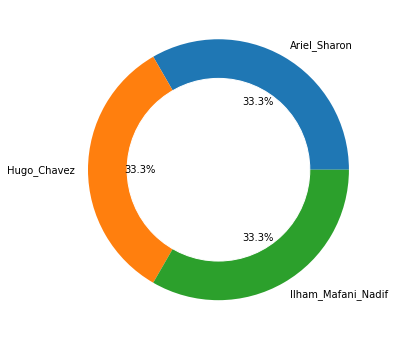

('Ariel_Sharon', 66)
('Hugo_Chavez', 66)
('Ilham_Mafani_Nadif', 66)
Jumlah Data MTCNN setelah Balancing :  198


YOLO


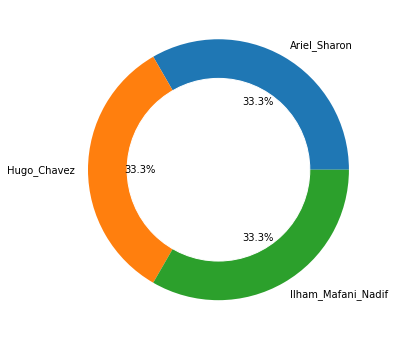

('Ariel_Sharon', 66)
('Hugo_Chavez', 66)
('Ilham_Mafani_Nadif', 66)
Jumlah Data YOLO setelah Balancing :  198


In [42]:
balancing(mtcnn_names, mtcnn_images, "MTCNN")
balancing(yolo_names, yolo_images, "YOLO")

In [43]:
import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Flatten

In [44]:
import os
import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPool2D, Flatten

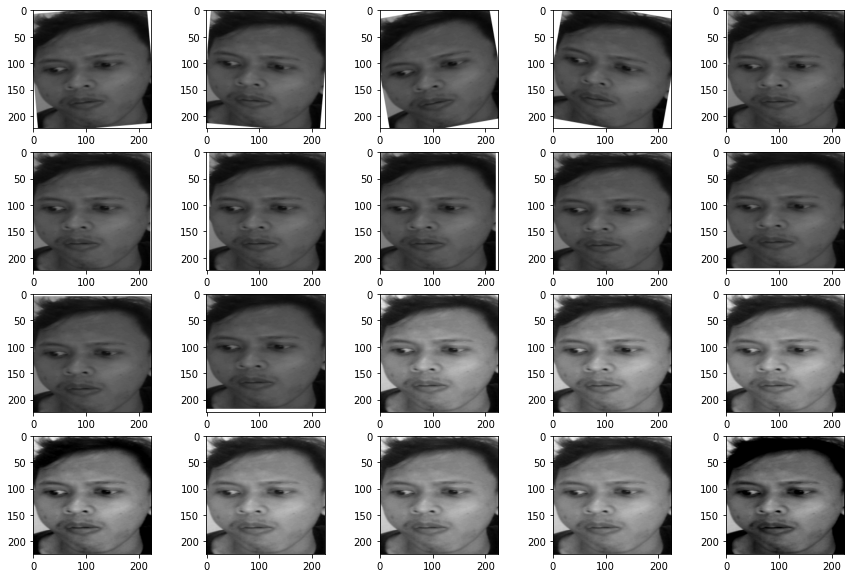

In [45]:
img_test = yolo_bal[195]

augmented_image_test = img_augmentation(img_test)

plt.figure(figsize=(15,10))
for i, img in enumerate(augmented_image_test):
    plt.subplot(4,5,i+1)
    plt.imshow(img, cmap="gray")
plt.show()

In [46]:
augmented_data(mtcnn_bal, mtcnn_bn, "MTCNN")

Data Awal MTCNN: 221
Data Balancing MTCNN: 198
Data Augmented MTCNN: (3960, 3960)


In [47]:
augmented_data(yolo_bal, yolo_bn, "YOLO")

Data Awal YOLO: 221
Data Balancing YOLO: 198
Data Augmented YOLO: (3960, 3960)


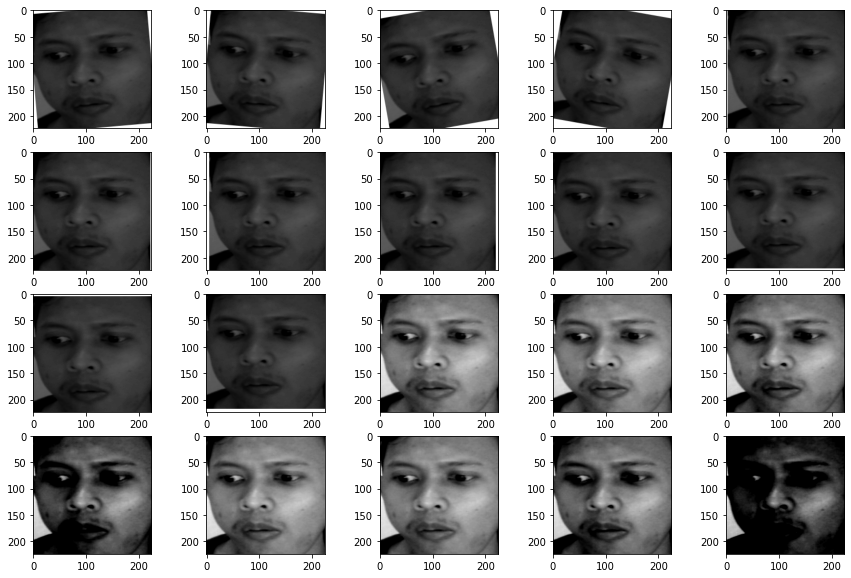

In [48]:
img_test = aug_img_mtcnn[3959]

augmented_image_test = img_augmentation(img_test)

plt.figure(figsize=(15,10))
for i, img in enumerate(augmented_image_test):
    plt.subplot(4,5,i+1)
    plt.imshow(img, cmap="gray")
plt.show()

In [49]:
aug_name_mtcnn[3959]

'Ilham_Mafani_Nadif'

In [50]:
def cnn_model(input_shape, labels): 
    
    model = Sequential()
    
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    
    model.add(Conv2D(64,
                    (3,3),
                    padding="valid",
                    activation="relu",
                    input_shape=input_shape))
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    
    model.add(Conv2D(128,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    
    model.add(Conv2D(256,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    
    model.add(Conv2D(256,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(512,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    
    model.add(Conv2D(512,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    
    model.add(Conv2D(512,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Conv2D(512,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    
    model.add(Conv2D(512,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    
    model.add(Conv2D(512,
                    (3,3),
                    padding="valid",
                    activation="relu"))
    
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    model.add(Dense(4096, activation="relu"))
    model.add(Dense(4096, activation="relu"))
    model.add(Dense(len(labels)))
    model.add(Activation("softmax"))
    
    model.summary() 
    
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])
    
    return model

In [51]:
le = LabelEncoder()
class Training:
    def __init__(self, names, images, title):
        self.name = names
        self.images = images     
        le.fit(names)
        labels = le.classes_
        name_vec = le.transform(names)
        categorical_name_vec = to_categorical(name_vec)
    
        x_train, x_test, y_train, y_test = train_test_split(np.array(images, dtype=np.float32),
                                                            np.array(categorical_name_vec),
                                                            test_size=0.15, 
                                                            random_state=42)
        
        x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
        x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
        
        self.xtrain = x_train
        self.xtest  = x_test
        self.ytrain = y_train
        self.ytest  = y_test
        self.label  = labels
        self.title  = title
    
    def xtest(self):
        return self.xtest
    
    def ytest(self):
        return self.ytest
    
    def label(self):
        return self.label
    
    def train_start(self):
        input_shape = self.xtrain[0].shape
        EPOCHS = 10
        BATCH_SIZE = 32
        model = cnn_model(input_shape, self.label)
        history = model.fit(self.xtrain, 
                            self.ytrain,
                            epochs=EPOCHS,
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            validation_split=0.15   # 15% dataset untuk testing/validasi
                            )
        self.history = history
        self.model = model
        
    def export_model(self):
        return self.model
    
    def evaluate_model(self):
        names = [['accuracy', 'val_accuracy'], 
                 ['loss', 'val_loss']]
        
        for name in names :
            fig1, ax_acc = plt.subplots()
            plt.plot(self.history.history[name[0]])
            plt.plot(self.history.history[name[1]])
            plt.xlabel('Epoch')
            plt.ylabel(name[0])
            plt.title('Model ' + self.title + ' - '+ name[0])
            plt.legend(['Training', 'Validation'], loc='lower right')
            plt.grid()
            plt.show()

In [52]:
mtcnn = Training(aug_name_mtcnn, aug_img_mtcnn, "MTCNN")
yolo  = Training(aug_name_yolo, aug_img_yolo, "YOLO")

In [53]:
un_mtcnn = Training(mtcnn_names, mtcnn_images, "MTCNN")
un_yolo  = Training(yolo_names, yolo_images, "YOLO")

In [54]:
mtcnn.train_start()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 128)      0         
 2D)                                                    

In [55]:
yolo.train_start()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 222, 222, 64)      640       
                                                                 
 conv2d_14 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 110, 110, 64)     0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 108, 108, 128)     73856     
                                                                 
 conv2d_16 (Conv2D)          (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 53, 53, 128)      0         
 2D)                                                  

In [56]:
un_mtcnn.train_start()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 222, 222, 64)      640       
                                                                 
 conv2d_27 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 108, 108, 128)     73856     
                                                                 
 conv2d_29 (Conv2D)          (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

In [57]:
un_yolo.train_start()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 222, 222, 64)      640       
                                                                 
 conv2d_40 (Conv2D)          (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 110, 110, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 108, 108, 128)     73856     
                                                                 
 conv2d_42 (Conv2D)          (None, 106, 106, 128)     147584    
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 53, 53, 128)      0         
 g2D)                                                 

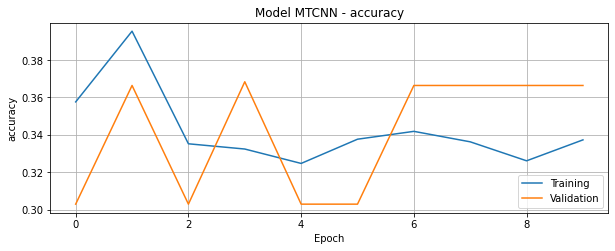

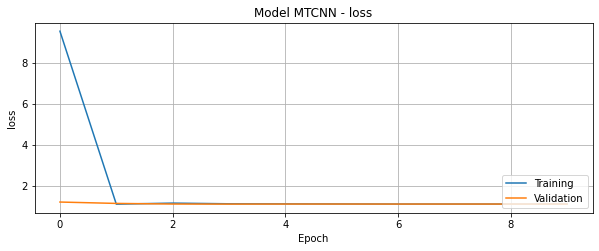

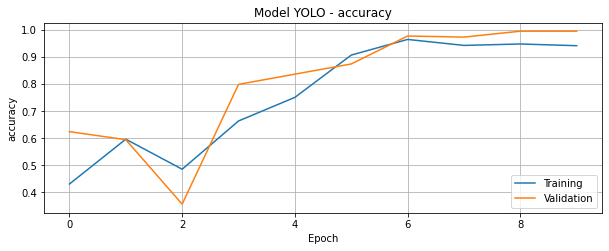

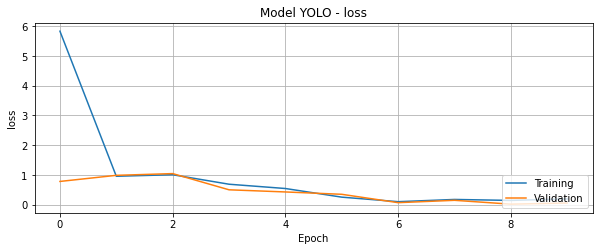

In [69]:
mtcnn.evaluate_model()
yolo.evaluate_model()

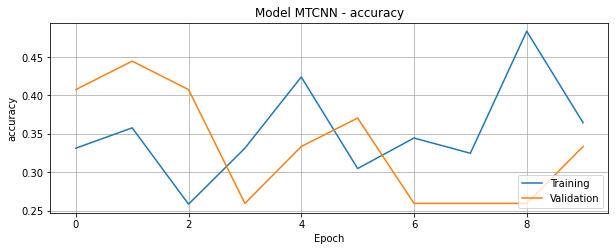

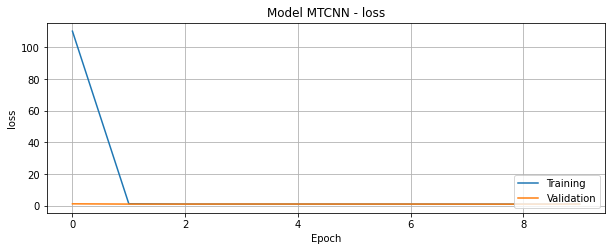

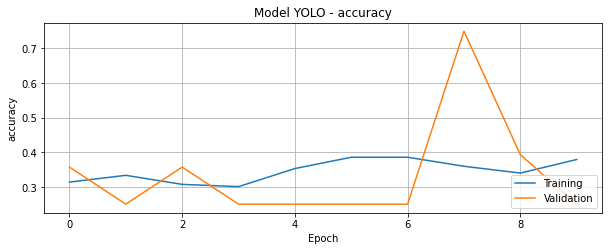

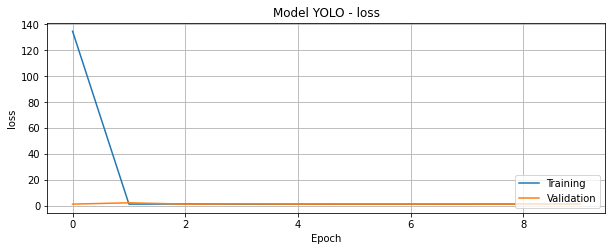

In [61]:
un_mtcnn.evaluate_model()
un_yolo.evaluate_model()

In [65]:
mtcnn.export_model().save("VGG_MTCN.h5")
yolo.export_model().save("VGG_YOLO.h5")
un_mtcnn.export_model().save("VGG_unMTCN.h5")
un_yolo.export_model().save("VGG_unYOLO.h5")

In [66]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 8))
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

## Pengujian Model dengan Confussion Matrix

In [67]:
def conf(x_test, y_test, model, title, labels): 
    y_pred = model.predict(x_test)
    cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
    np.set_printoptions(precision=2)
    print("\n\n")
    plot_confusion_matrix(cnf_matrix, classes=labels,normalize=False, title='Confusion Matrix ' + title)
    print(classification_report(y_test.argmax(axis=1), 
                            y_pred.argmax(axis=1), 
                            target_names=labels))

19/19 [==============================] - 27s 1s/step





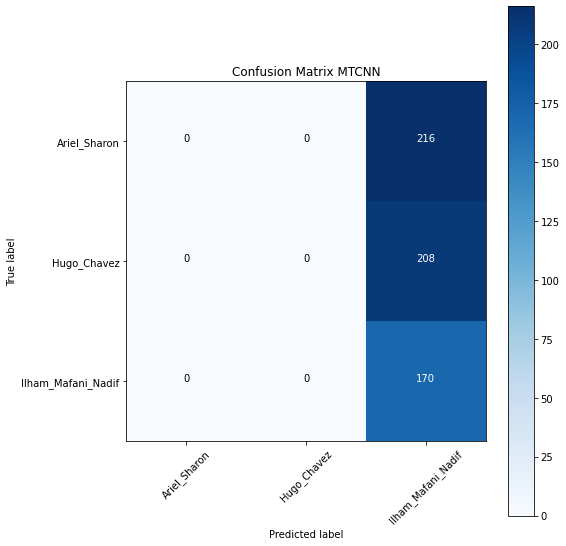

                    precision    recall  f1-score   support

      Ariel_Sharon       0.00      0.00      0.00       216
       Hugo_Chavez       0.00      0.00      0.00       208
Ilham_Mafani_Nadif       0.29      1.00      0.45       170

          accuracy                           0.29       594
         macro avg       0.10      0.33      0.15       594
      weighted avg       0.08      0.29      0.13       594



C:\Users\Ilham Mafani Nadif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ilham Mafani Nadif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ilham Mafani Nadif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

19/19 [==============================] - 27s 1s/step





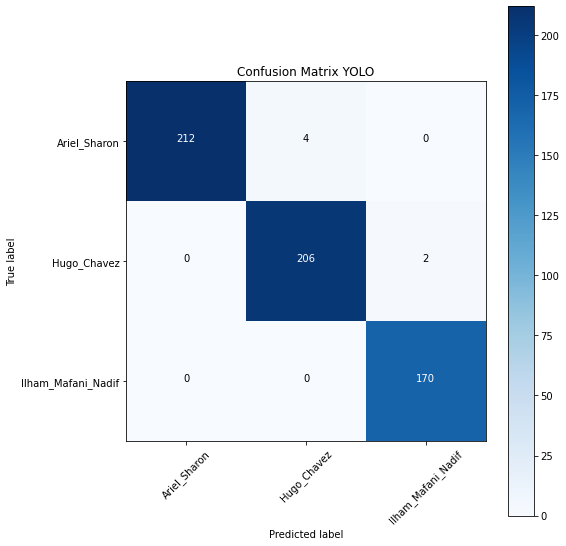

                    precision    recall  f1-score   support

      Ariel_Sharon       1.00      0.98      0.99       216
       Hugo_Chavez       0.98      0.99      0.99       208
Ilham_Mafani_Nadif       0.99      1.00      0.99       170

          accuracy                           0.99       594
         macro avg       0.99      0.99      0.99       594
      weighted avg       0.99      0.99      0.99       594

1/1 [==============================] - 2s 2s/step





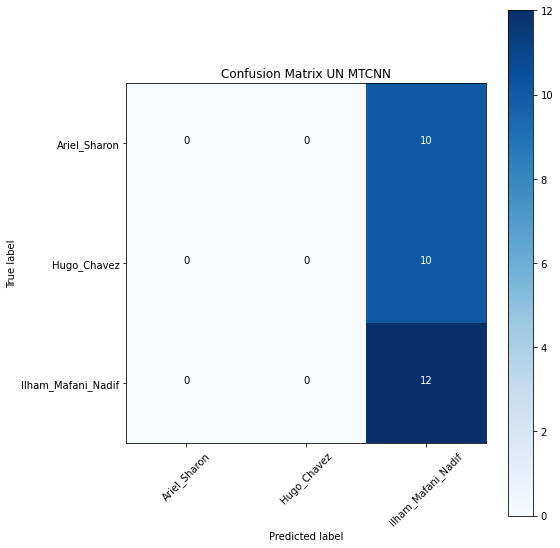

                    precision    recall  f1-score   support

      Ariel_Sharon       0.00      0.00      0.00        10
       Hugo_Chavez       0.00      0.00      0.00        10
Ilham_Mafani_Nadif       0.38      1.00      0.55        12

          accuracy                           0.38        32
         macro avg       0.12      0.33      0.18        32
      weighted avg       0.14      0.38      0.20        32



C:\Users\Ilham Mafani Nadif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ilham Mafani Nadif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ilham Mafani Nadif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

2/2 [==============================] - 2s 99ms/step





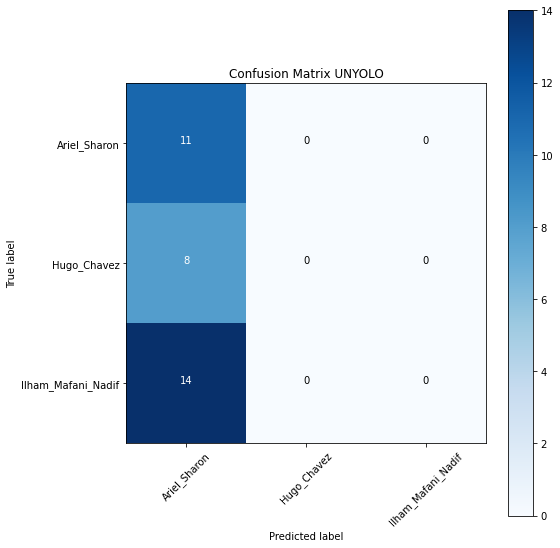

                    precision    recall  f1-score   support

      Ariel_Sharon       0.33      1.00      0.50        11
       Hugo_Chavez       0.00      0.00      0.00         8
Ilham_Mafani_Nadif       0.00      0.00      0.00        14

          accuracy                           0.33        33
         macro avg       0.11      0.33      0.17        33
      weighted avg       0.11      0.33      0.17        33



C:\Users\Ilham Mafani Nadif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ilham Mafani Nadif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ilham Mafani Nadif\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [68]:
conf(mtcnn.xtest, mtcnn.ytest, mtcnn.export_model(), "MTCNN", mtcnn.label)
conf(yolo.xtest, yolo.ytest, yolo.export_model(), "YOLO", yolo.label)
conf(un_mtcnn.xtest, un_mtcnn.ytest, un_mtcnn.export_model(), "UN MTCNN", un_mtcnn.label)
conf(un_yolo.xtest, un_yolo.ytest, un_yolo.export_model(), "UNYOLO", un_yolo.label)